# ADM HW_3

##### Mert YILDIZ / Nello Castaldo / Luca Avitabile



## Q-1. Data collection

### 1.1. Get the list of books

#### In the following chunk you will find libraries needed for the execution of the code 

In [8]:
from bs4 import BeautifulSoup as soup
import requests
import time
import urllib.request
import urllib.error as uer
from pathlib import Path
from lxml import etree, html
import regex as re
import csv
import pandas as pd
from langdetect import detect
from tqdm import tqdm
import nltk
import io 
import codecs
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import stem
from string import punctuation
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
from collections import Counter
import heapq
import math
from scipy import spatial

#### in the following chunck we obtained the complete list of the 300 pages from which we took every 30 thousand book

In [9]:
url_rank = []
for i in tqdm(range(1,301)):
    url_rank.append('https://www.goodreads.com/list/show/1.Best_Books_Ever?page={}'.format(i))

string_for_parsing = 'https://www.goodreads.com' #url of the site

link_to_download = []
for num_page in tqdm(url_rank):
    book_prova  = requests.get(num_page)
    page = soup(book_prova.text, 'html.parser')
    domenica = page.find_all('a', {'class' : 'bookTitle'})
    for item in domenica:
        link_to_download.append(string_for_parsing+item['href'])

#write txt file 
with open('urls.txt', 'w') as f:
    for item in tqdm(link_to_download):
        f.write("%s\n" % item)

100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 240878.91it/s]


### 1.2. Crawl books

In [11]:
Path("directory").mkdir(exist_ok=True)

for i in range(1,4):
    FolderName = 'folder{}'.format(i)
    Path(FolderName).mkdir(exist_ok=True) #with this line we create folders for storing html files 
    
def download_html():
    id = int(input())  #we split download in 3 parts to work in parallel
                        #Luca = 1  #Mert = 2  #Nello = 3
    if id ==1:
        a = 0
        b = 10
        i = 0
    elif id ==2:
        a = 11900
        b = 20000
        i = 99
    elif id == 3:
        a = 20000
        b = 30000
        i = 199
    
    for url in range(a,b):
        
        if url == 0 or url%100 == 0:
            i += 1
            folder_name = 'html_books_{}'.format(i)
            Path(folder_name).mkdir(exist_ok=True)  #with this line we create folders for storing html files 
        urllib.request.urlretrieve(link_to_download[url], 'html_books_{}/article_{}.html'.format(i,url+1))
        
download_html()

1


### 1.3 Parse downloaded pages

#### In this chunck is reported the code of the funtion which write tsv files from html files useful for search engines

In [ ]:
def tsv_writer():
    
    print('Insert Path ')  #we grouped every pages' folders in a single folder to make every file more tidy in our pc
    
    path = input()
    
    print('Insert directory')  #first part of the name of each folder
    
    directory = input()
    
    count_error = []
    
    for j in range(0,301):  #in this for loop we take every book of every page
        a = 1 + 100*(j)
        b = 101 + 100*(j)
        for k in range(a,b):
            
            try: #we applied this try/except because some html files are corrupted or missed

                HtmlFile = open(path+'/'+directory+str(j)+'/article_{}.html'.format(k), 'r', encoding='utf-8')

                source_code = HtmlFile.read()  #code to go into the html page

                book = soup(source_code, 'html.parser')  #using beautiful soup
                
#now we take every single info needed using the path wrote in html document                

                book_title = book.find('h1',{'id':'bookTitle'}).contents[0].strip()

                book_series = book.find('h2',{'id':'bookSeries'})

                if book_series.text.strip() == '':
                    series = ''
                else:
                    series = book_series.contents[1].contents[0].strip()

                author = book.find('span',{'itemprop':'name'}).contents[0]

                rating = float(book.find('span',{'itemprop':'ratingValue'}).contents[0].strip())

                number_of_rating = int(book.find('meta',{'itemprop':'ratingCount'}).contents[0].split()[0].replace(',',''))

                review_count = int(book.find('meta',{'itemprop':'reviewCount'})['content'])

                number_of_pages = int(book.find('span',{'itemprop':'numberOfPages'}).contents[0].split()[0])

                publishing_date = book.find('div',{'class':'row'}).find_next_sibling().contents[0].split()[1:4]

                plot = book.find('div',{'id':'description'})
                
                try:     #we needed this try/except because some book hasn't the plot            
                
                    complete_plot = plot.find_all('span')
                    
                    if detect(str(complete_plot)) != 'en':
                        continue
                
                except: 
                    
                    complete_plot = ''
                    

                details = book.find('div',{'id':'bookDataBox'})

                places = details.find_all('a', {'href': re.compile(r'/places')})

                settings = ''
                for item in places:
                    settings += item.text+','


                character_sw = details.find_all('a', {'href': re.compile(r'/characters')})

                character = ''
                for item in character_sw:
                    character+= item.text+','
            
            except:
                
                count_error.append((a,j))
                
                continue


            with open('books_tsv/article_{}.tsv'.format(k), 'wt', encoding="utf-8") as out_file:
                    tsv_writer = csv.writer(out_file, delimiter='\t')
                    tsv_writer.writerow(['book_title','book_series','author','rating','number_of_rating',
                                         'review_count','number_of_pages','publishing_date','complete_plot','places','characters'])
                    tsv_writer.writerow([book_title,series,author,rating,number_of_rating,review_count,number_of_pages,
                                        publishing_date,complete_plot,settings,character])                    


In [20]:
tsv_writer()  #comand to lunch the function

Insert Path 
books
Insert directory
html_books_


# 2. Search Engine

Now, we want to create two different Search Engines that, given as input a query, return the books that match the query.

First, we have pre-processed all the information collected for each book by

* Removing stopwords
* Removing punctuation
* Stemming


In [2]:
def cleaner(text):

    words = re.split(r'\W+', str(text))   #split the text
    words = [word.lower() for word in words]  #convert words to lower 
    without_punct = [wp for wp in words if wp not in punctuation] #remove punctuation
    sw = stopwords.words('english')  #define stopwords
    without_sw = [w for w in without_punct if w not in sw]  #remove stopwords 
    list_to_remove = ['b','br','span', 'one' , 'id', 'none' ] # define other unwanted words 
    clean_more = [w for w in without_sw if w not in list_to_remove] # remove them
    clean_more_2 = [w for w in clean_more if  not (re.findall(re.compile(r'freetext'),w)
                                                   or re.findall(re.compile(r'\d'),w)) ]  #remove some tags that were not properly removed
    
    
    ps = nltk.stem.PorterStemmer()
    stemmed_list=[ps.stem(w) for w in clean_more_2 ]  # stemming
    return ' '.join(stemmed_list) # merge all the words in the list and return a string 

### 2.1. Conjunctive query

#### 2.1.1) Create your index!

Before building the index,

We have created a file named vocabulary, in the .csv format, that maps each word to an integer (term_id).
Then, the first brick of the homework is to create the Inverted Index. It will be a dictionary of this format:

{

term_id_1:[document_1, document_2, document_4],

term_id_2:[document_1, document_3, document_5, document_6],

...}

where document_i is the id of a document that contains the word.

In [107]:
text=''  # string for all the books strings 
for books in range(1,30001): 
    text_1='' # string for each book string
    try:
        df = pd.read_csv("books_3_tsv/article_"+str(books)+".tsv", sep='\t', encoding='utf-8' ) # read tsv file of book
    except:
        continue
    df = df.fillna("")  #fill nan info 
    df['book_title']=df['book_title'].apply(cleaner)  # clean the title
    df['complete_plot']=df['complete_plot'].apply(cleaner) #clean the plot 
    

    #df.to_csv('cleaned_csv/prova_libro_'+str(books)+'.csv') # create new cleaned csv using this line, run only once
    
    #now create the vocabulary
    
    title = df.iloc[0, 0]  #get the title 
    plot = df.iloc[0, 8] #get the plot
    text = text + " " + title + " " + plot # update final string 
    text_1 = title + " " + plot #update  local string 
    arr_1=set(text_1.split()) #create a set from the local splitted string 
    file = open("txt_files/article_"+str(books)+".txt", "w") #create a txt file for each book that contains the set 
    file.write(str(arr_1))  #write the file
    file.close()  #close the file 

arr = set(text.split()) # use set to eliminate repeating words from final string 
vocab = pd.DataFrame(arr) # create a dataframe from the set 
vocab.to_csv("vocab.csv") #save vocabulary as csv with indices for each vocab

In [7]:
df_voc= pd.read_csv('vocab.csv')  # read the vocabulary just created 

df_voc.columns=['id','word'] # change columns names

d = defaultdict(set) # create a new defaultdict to save the iverted index 

### Inverted index 

In [13]:
def extract_words_2(id): # read the txt files of the documents 
    try:
        
        file = open("txt_files/article_"+str(doc)+ ".txt", "r") 
        test=ast.literal_eval(file.read()) #evaluate the set in the txt file 
        file.close()
        return test #return the set evaluated 
    except:
        return [] #return empty list if some errors occur

In [37]:
for doc in range(1,30001): #fill the inverted index 
    test=extract_words_2(doc) # get the book set of words 
    for item in test: 
       
        d[item].add(doc)  #update the list of documents of word 'item'
    

dic_keys=d.keys()  #words in the inverted index 
new_dic=defaultdict(set) #new inverted index to translate word into id
for item in dic_keys: 
    try:
        new_key=df_voc[df_voc.word==item].id.iloc[0] # get the id of the word from vocabulary
        new_dic[new_key]=d[item] # copy the list of documents in the new inverted index with id as key
    except:
        continue

file = open("inverted_index_1.txt", "w")  #save inverted index as txt file 
file.write(str(new_dic))
file.close() 

### 2.1.2) Execute the query

In [299]:
def search_query():
    query= str(input('Insert the query ')) #ask for the query
    final_query=cleaner(query) # preprocess the query
    word_list=final_query.split() #get the list of words of the query
    key_list=[] # list to save id of the words in the query
    for word in word_list:
        key=df_voc[df_voc.word==word].id.iloc[0] #get id of each word  from vocabulary
        key_list.append(key) #add to key_list
    try:
        result=new_dic[key_list[0]] #get the list of documents of first word of the query
    except:
        print('No results found')
        return [] #if key_list is empty return an empty list
    for item in key_list: # execute the intersection between all the lists of documents 
        result=result.intersection(new_dic[item]) #update result with intersection
        
    return result #return the documents that contains all the words of the query

In [317]:
books=search_query()  #call the function and save the result in books

Insert the query winnie


In [351]:
def find_link(index): #given the doc index return the link 
    ind=str(index) 
   
    folder= math.floor((index-1) /100) # find the folder that contains the html file of the book
    HtmlFile = open('books_3/html_books_'+str(folder)+'/article_{}.html'.format(ind), 'r', encoding='utf-8') #open the file 
    source_code = HtmlFile.read() #read it 

    book = soup(source_code, 'html.parser') # parse the content of the file 

    book_link = book.find('link') # find the link in link element 
    
    return book_link['href'] #return the value of href attribute 

In [352]:
for index in books:  # for all the books in the result of the function 
    df = pd.read_csv("books_3_tsv/article_"+str(index)+".tsv", sep='\t', encoding='utf-8' ) #read the tsv file 
    plot_split=re.split(r'\W+', str(df['complete_plot'].iloc[0])) # split the plot 
    title=df['book_title'].iloc[0] # get the title 
    list_to_remove = ['b','br','span', 'one' , 'id', 'none','[',']'] # words that will be removed 
    clean_more = [w for w in plot_split if w not in list_to_remove] # remove them   
    clean_more_2 = [w for w in clean_more if  not (re.findall(re.compile(r'freetext'),w)
                                                   or re.findall(re.compile(r'\d'),w)) ] # remove other unwanted elements 
    url=find_link(index) #find the link of the book
    
    print(title, ':' ,' '.join(clean_more_2),url) # print the title, the plot and the url 
    print('\n\n\n')
    

Walt Disney's Winnie-the-Pooh and the Honey Patch : nan https://www.goodreads.com/book/show/6394554-walt-disney-s-winnie-the-pooh-and-the-honey-patch




A Dragon's Guide to the Care and Feeding of Humans :  Crusty dragon Miss Drake has a new pet human precocious Winnie Oddly enough Winnie seems to think Miss Drake is her pet a ridiculous notion Unknown to most of its inhabitants the City by the Bay is home to many mysterious and fantastic creatures hidden beneath the parks among the clouds and even in plain sight And Winnie wants to draw every new creature she encoun style display Crusty dragon Miss Drake has a new pet human precocious Winnie Oddly enough Winnie seems to think Miss Drake is her pet a ridiculous notion Unknown to most of its inhabitants the City by the Bay is home to many mysterious and fantastic creatures hidden beneath the parks among the clouds and even in plain sight And Winnie wants to draw every new creature she encounters the good the bad and the ugly But Winnie

## 2.2) Conjunctive query & Ranking score

### 2.2.1) Inverted index


In [354]:
for books in range(1,30001): # create a counter for each book
    text_1='' # string of words in the document
    try:
        df = pd.read_csv("books_3_tsv/article_"+str(books)+".tsv", sep='\t', encoding='utf-8' ) #read tsv files
    except:
        continue
    df = df.fillna("") #fill empty values 
    df['book_title']=df['book_title'].apply(cleaner) # clean the title 
    df['complete_plot']=df['complete_plot'].apply(cleaner) #clean the book
     

    #df.to_csv('cleaned_csv/prova_libro_'+str(books)+'.csv') #to create new cleaned csv, run once 
    
    
    
    title = df.iloc[0, 0] # get the title 
    plot = df.iloc[0, 8] #get the plot 
    text_1 = title + " " + plot # update the text of the document 
    arr_1=(text_1.split()) # split the text string 
    c = Counter(arr_1)  # create a dictionary with the number of occurences for each word
    file = open("txt_files_2/article_"+str(books)+".txt", "w")  # save it in a txt files 
    file.write(str(c)) 
    file.close() 


In [356]:
d = defaultdict(list)  #create a defaultdict. keys: word , values: (document id, occurrences of the word)

In [357]:
def extract_from_counter(id): #given the index of the book it reads the dictionary in txt file and returns it 
    try:
        
        file = open("txt_files_2/article_"+str(doc)+ ".txt", "r") #open the file 
        dic=file.read() # read it 
        prova=dic.replace('Counter(','').replace(')','') # clean the content to be evaluated 
        test=ast.literal_eval(prova) #evaluate the dictionary saved as a string in the txt file 
        file.close()
        return test
    except:
        return {} # return empty dictionary if some errors occur 

In [358]:
for doc in range(1,30001):   #fill the defaultdict d with all the documents
    result=extract_from_counter(doc) #get the Counter 
    for key in result.keys(): # update dictionary 
        heapq.heappush(d[key],(result[key],doc)) # using heap to store values and to keep the order
       

In [359]:
dic_keys=d.keys() # create a new dictionary to subsitute words with words_id
new_dic=defaultdict(list) 
for item in dic_keys:
    try:
        new_key=df_voc[df_voc.word==item].id.iloc[0] # find the word id from the vocabulary
        new_dic[new_key]=d[item] # copy the values in the new dictionary
    except:
        continue

In [360]:
#save the lenght of each document in a dictionary
dic_lenght=defaultdict(int)

for doc in range(1,30001): # fill dic_lenght with all the documents lenghts 
    result=extract_from_counter(doc) #get the Counter 
    lenght=sum(result.values()) # sum the values of the Counter of the document 
    if(lenght==0):
        continue
    dic_lenght[doc]=lenght #update the value in the dictionary
documents_number=30000 # numbers of documents in the collection

# save the number of documents for each word in a different dictionary
documents_with_word= defaultdict(int) 
for item in d.keys(): 
    documents_with_word[item]=len(d[item]) 

In [361]:
#create again the dictionary with the heap ordered by tf_idf
final_inverted_index=defaultdict(list) #this is the final inverted indev with words as keys.
for doc in range(1,30001):
    result=extract_from_counter(doc)
    doc_len=dic_lenght[doc] # get the len of the document 
    for key in result.keys(): 
        tf= result[key] / doc_len
        idf= math.log(documents_number / documents_with_word[key] ,10) 
        tf_idf= tf * idf #find tfidf
        heapq.heappush(final_inverted_index[key],(tf_idf,doc)) # the list is ordered by the tfidf using a heap 

In [362]:
#change the word with the numbers  
dic_keys=final_inverted_index.keys()
inverted_index_tfidf=defaultdict(list)  #final inverted index
for item in dic_keys:
    try:
        new_key=df_voc[df_voc.word==item].id.iloc[0] #get the id of the word from vocabulary
        inverted_index_tfidf[new_key]=final_inverted_index[item] # copy the value of the ol dictionary in the final inverted index
    except:
        continue

In [363]:
file= open('inverted_index_1.txt','r') #read the inverted index of the previous search engine 
obj= file.read()
new_dic=ast.literal_eval(obj) #evaluate string as dictionary

In [364]:
def find_tfidf(word_list): # given a list, this functions returns the tfidf_vector for the list of words 
    c=Counter(word_list)  # number of occurences of the word 
    res_vec=[] 
    string_len=len(word_list) # len of the list 
    for word in word_list: # calculate the tfidf for all the word in the query 
        tf=c[word]/string_len
        idf= math.log(documents_number / documents_with_word[word] ,10) 
        res_vec.append(tf*idf) # append the result to the vector 
    return res_vec

### 2.2.2) Execute the query


In [365]:
## Process the query
def search_query(): #the search engine is similar to the previous one, but in this case we use it to filter the list of
                    # documents that contains all the words of the query. We will apply the cosine similarity function to this books
    query= str(input('Insert the query '))
    final_query=cleaner(query) #clean the query
    word_list=final_query.split() #list of words 
    tf_idf=find_tfidf(word_list) # tfidf vector of the query
    key_list=[]
    for word in word_list: # find the id of each word in the query using vocabulary
        key=df_voc[df_voc.word==word].id.iloc[0]
        key_list.append(key) #update list of id 
    try:
        result=new_dic[key_list[0]]  # get the list of documentsof first word 
    except:
        print('No results found for the input query') # if it is empty return 
        return 0,0,0
   
    for item in key_list:
        result=result.intersection(new_dic[item]) # get the intersection between all the list of documents 
        
    return result,key_list,tf_idf  #it returns the set of documents, the words in the query, and the tf_idf vector of the query

In [366]:
res,key_list,tf_vector=search_query()   # call the function

Insert the query love hard pain


In [377]:
result_list=[] 
for book in res: # for each book in result we create the tfidf_vector. The lenght of the vector is equal to the length 
                # of the tfidf_vector of the query
    vec=[]
    for key in key_list:
        data_frame= pd.DataFrame(inverted_index_tfidf[key])#convert the values of the key in a dataframe 
        data_frame.columns=['tf','doc']
        vec.append(data_frame[data_frame.doc== book].tf.iloc[0]) # search the tfidf value filtering the dataframe 
   
    similarity= 1 - spatial.distance.cosine(tf_vector,vec) # for each book we apply the cosine similarity
    result_list.append((similarity, book)) # store the result in a list

final_list=heapq.nlargest(4,result_list)  # get the top 4 results 

In [378]:
result_dataframe= pd.DataFrame(columns=['Title','Plot','Url','Similarity']) #create a dataframe to store the results 
#create a list for each field  
title_list=[]
plot_list=[]
url_list=[]
sim_list=[]
for similar,index in final_list:  # for each book we print the title, the plot, the url and the cosine similarity
    df = pd.read_csv("books_3_tsv/article_"+str(index)+".tsv", sep='\t', encoding='utf-8' ) #read the file 
    plot_split=re.split(r'\W+', str(df['complete_plot'].iloc[0])) # split the plot 
    title=df['book_title'].iloc[0] #get the title 
    list_to_remove = ['b','br','span', 'one' , 'id', 'none','[',']'] 
    clean_more = [w for w in plot_split if w not in list_to_remove] 
    clean_more_2 = [w for w in clean_more if  not (re.findall(re.compile(r'freetext'),w)
                                                   or re.findall(re.compile(r'\d'),w)) ] # clean again the plot
    url=find_link(index) #find the link 
    #update the different lists 
    title_list.append(title) 
    plot_list.append(' '.join(clean_more_2))
    url_list.append(url)
    sim_list.append(similar)
#update the dataframe using the lists 
result_dataframe['Title'] = title_list
result_dataframe['Plot'] = plot_list
result_dataframe['Url'] = url_list
result_dataframe['Similarity']=sim_list

In [379]:
result_dataframe

,Title,Plot,Url,Similarity
0,Unbearable Lightness: A Story of Loss and Gain,I didn t decide to become anorexic It snuck u...,https://www.goodreads.com/book/show/9219901-un...,1.000000
1,Most of All You,i A broken woman i Crystal learned long ago t...,https://www.goodreads.com/book/show/32854499-m...,0.969612
2,More Than Two: A Practical Guide to Ethical Po...,Can you love more than person Have multiple r...,https://www.goodreads.com/book/show/21955937-m...,0.956397
3,An Unexpected Blessing,i This is an alternate cover edition of ISBN ...,https://www.goodreads.com/book/show/52374459-a...,0.955570


### Note: Q-2 Search Engine with tfidf-cos similarity (Built-in functions)
##### For this question we have another solution which uses the built-in functions. Please see the solution and code below.

In [ ]:
# Create a csv files for all books with book title, cleaned plot, url and empty similarity column.
# The similarity score will be added to dataframe later

df_new = pd.DataFrame(columns = ['Book Title', 'Plot', 'Url','Similarity'])
title_list = []
plot_list = []
url_list = []

for index in tqdm(range(1,30000)):
    try:
        df = pd.read_csv("books_tsv/article_"+str(index)+".tsv", sep='\t', encoding='utf-8' )
    except:
        continue
    df['book_title'] = df['book_title'].apply(cleaner)
    title = df['book_title'].iloc[0]
    df['complete_plot']=df['complete_plot'].apply(cleaner)
    plot = df['complete_plot'].iloc[0]
    complete_plt= title + " " + plot
    plot_split = re.split(r'\W+', str(complete_plt))
    
    url=find_link(index)    
    title_list.append(title)
    plot_list.append(' '.join(plot_split))
    url_list.append(url)
    
df_new['Book Title'] = title_list
df_new['Plot'] = plot_list
df_new['Url'] = url_list
df_new.to_csv ('tfidf_cos.csv', index = False, header=True)

In [7]:
# Read the csv file created above

df_new = pd.read_csv("tfidf_cos.csv")

# Calculate the tfidf and cosine similarity score for all books with the query

vectorizer = TfidfVectorizer() # Get tf-idf matrix using fit_transform function
X = vectorizer.fit_transform(df_new['Plot'].values.astype('U')) # Store tf-idf representations of all docs

query = str(input('Search something: ')) # Ask the user to write the query

query_vec = vectorizer.transform([query]) # Ip -- (n_docs,x), Op -- (n_docs,n_Feats)
results = cosine_similarity(X,query_vec).reshape((-1,)) # Op -- (n_docs,1) -- Cosine Sim with each doc
cos_sim = results.tolist() # Convert the cosine similarity result to list format
df_new['Similarity'] = cos_sim # Write the similarity score to Similarity column of dataframe
    
df_new.nlargest(10,'Similarity') # Take the first 10 most similar books

Search something: last freedom


,Book Title,Plot,Url,Similarity
18331,first last freedom,first last freedom krishnamurti lead spiritu t...,https://www.goodreads.com/book/show/64710.The_...,0.427591
8203,love freedom alon koan relationship,love freedom alon koan relationship today worl...,https://www.goodreads.com/book/show/97008.Love...,0.426060
11982,found freedom unfre world handbook person liberti,found freedom unfre world handbook person libe...,https://www.goodreads.com/book/show/82104.How_...,0.355028
22317,seed america trilog chain forg ash,seed america trilog chain forg ash would risk ...,https://www.goodreads.com/book/show/29430512-t...,0.318160
4156,diari freedom writer experi,diari freedom writer experi survivor word cont...,https://www.goodreads.com/book/show/17879512-d...,0.291967
4361,escap freedom,escap freedom human cannot live danger respons...,https://www.goodreads.com/book/show/25491.Esca...,0.279686
19841,develop freedom,develop freedom winner nobel prize econom esse...,https://www.goodreads.com/book/show/173961.Dev...,0.265597
15236,capit freedom,capit freedom select time literari supplement ...,https://www.goodreads.com/book/show/51877.Capi...,0.255351
19386,ann mccaffrey freedom collect freedom land fre...,ann mccaffrey freedom collect freedom land fre...,https://www.goodreads.com/book/show/24867.Anne...,0.240459
17584,escap,escap nearli ten year captiv grace readi make ...,https://www.goodreads.com/book/show/21470020-e...,0.229970


## Q-3. Define a new score!

As it has been requested we have added a new filter. We are asking to user to enter the query and the minimum rating for the books. We have defined a new score which is taking the rating into account and normalize it then multiply by cosine similarity. Then we are showing the 10 books with the highest new score that has been defined.

In [25]:
# Create a csv files for all books with cleaned book title, rating, cleaned plot, url, empty similarity and score column.
# The similarity and new score that has been defined will be added to dataframe later.

df_new = pd.DataFrame(columns = ['Book Title','Rating', 'Number_of_Rating', 'Plot', 'Url', 'Similarity', 'Score'])
title_list = []
plot_list = []
url_list = []
rating_list = []
num_rating_list = []

for index in tqdm(range(1,30000)):
    try:
        df = pd.read_csv("books_tsv/article_"+str(index)+".tsv", sep='\t', encoding='utf-8' )
    except:
        continue
    df['book_title'] = df['book_title'].apply(cleaner)
    title = df['book_title'].iloc[0]
    df['complete_plot']=df['complete_plot'].apply(cleaner)
    plot = df['complete_plot'].iloc[0]
    complete_plt= title + " " + plot
    plot_split = re.split(r'\W+', str(complete_plt))
    rate = df['rating'].iloc[0]/5 # Normalize the rating
    num_rating = df['number_of_rating'].iloc[0]
    
    url=find_link(index)    
    title_list.append(title)
    plot_list.append(' '.join(plot_split))
    url_list.append(url)
    rating_list.append(rate)
    num_rating_list.append(num_rating)
    
df_new['Book Title'] = title_list
df_new['Plot'] = plot_list
df_new['Url'] = url_list
df_new['Rating'] = rating_list
df_new['Number_of_Rating'] = num_rating_list
df_new.to_csv ('tfidf_cos2.csv', index = False, header=True)


100%|████████████████████████████████████████████████████████████████████████████| 29999/29999 [56:40<00:00,  8.82it/s]


In [19]:
# Calculate the tfidf and cosine similarity score for all books with the query
df_new = pd.read_csv("tfidf_cos2.csv")

vectorizer = TfidfVectorizer() # Get tf-idf matrix using fit_transform function
X = vectorizer.fit_transform(df_new['Plot'].values.astype('U')) # Store tf-idf representations of all docs

query = str(input('Search something: ')) # Ask the user to write the query
min_rating = np.float(input('Minimum rating: ')) # We have asked to user to write the minimum rating he/she wants
min_number_rating = np.int(input('Minimum number of rating: ')) # We have asked to user to write the minimum rating he/she wants

df_empty = pd.DataFrame(columns = ['Book Title', 'Rating', 'Number_of_Rating', 'Plot', 'Url', 'Similarity', 'Score'])

query_vec = vectorizer.transform([query]) # Ip -- (n_docs,x), Op -- (n_docs,n_Feats)
results = cosine_similarity(X,query_vec).reshape((-1,)) # Op -- (n_docs,1) -- Cosine Sim with each doc
cos_sim = results.tolist() # Convert the cosine similarity result to list format
df_new['Similarity'] = cos_sim
df_new['Score'] = cos_sim * df_new['Rating']  # Calculate the score as cosine_similarity*rating and write to Score column of dataframe

df_new[(df_new['Number_of_Rating'] > min_number_rating) & (df_new['Rating']*5 > min_rating)].nlargest(10,'Score')


Search something: love life
Minimum rating: 4
Minimum number of rating: 20000


,Book Title,Rating,Number_of_Rating,Plot,Url,Similarity,Score
2216,thief,0.874,34377,thief note self love patient love kind love bo...,https://www.goodreads.com/book/show/16090981-t...,0.380172,0.332270
2684,art love,0.806,53172,art love fiftieth anniversari edit groundbreak...,https://www.goodreads.com/book/show/14142.The_...,0.381103,0.307169
877,love languag secret love last,0.850,300738,love languag secret love last div p simpl idea...,https://www.goodreads.com/book/show/23878688-t...,0.343241,0.291755
6749,four love,0.828,44040,four love four love summar four kind human lov...,https://www.goodreads.com/book/show/29938407-t...,0.323872,0.268166
7267,lilli,0.854,27827,lilli cash mayson forc choos love life unborn ...,https://www.goodreads.com/book/show/18781540-u...,0.255823,0.218473
10660,cours love,0.810,25785,cours love engross tale provid plenti food tho...,https://www.goodreads.com/book/show/27845690-t...,0.251856,0.204003
339,NaN,0.852,1158061,new york time bestsel author giver star disco...,https://www.goodreads.com/book/show/17347634-m...,0.221267,0.188520
4083,crash,0.910,41104,crash life crash around us hard will fight thi...,https://www.goodreads.com/book/show/30166123-c...,0.202856,0.184599
8946,love dare,0.878,52135,love dare new york time best seller million un...,https://www.goodreads.com/book/show/4499669-th...,0.191880,0.168471
19191,citi girl,0.808,160745,citi girl new york time bestsel author eat pra...,https://www.goodreads.com/book/show/51918871-c...,0.207864,0.167954


## Q-5. Algorithmic Question

You are given a string written in english capital letters, for example S="CADFECEILGJHABNOPSTIRYOEABILCNR." You are asked to find the maximum length of a subsequence of characters that is in alfabetical order. For example, here a subsequence of characters in alphabetical order is the "ACEGJSTY": "CADFECEILGJHABNOFPSTIRYOEABILCNR." Among all the possible such sequences, you are asked to find the one that is the longest.

1. Write a recursive program that, given a string, computes the length of the subsequence of maximum length that is in alphabetical order. Try some examples. Are the examples of short strings correct? Can you find examples that your algorithm does not terminate in reasonable time?

In [38]:
import time
start_time = time.time()

def recursive_lcs(Y, X, m, n): 
  
    if m == 0 or n == 0: 
        return 0; 
    elif Y[m-1] == X[n-1]: 
        return 1 + recursive_lcs(Y, X, m-1, n-1); 
    else: 
        return max(recursive_lcs(Y, X, m, n-1), recursive_lcs(Y, X, m-1, n)); 

print("--- %s seconds ---" % (time.time() - start_time))
 
Alphabet_S = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
Input_S =  input("Please enter a sequence with upper cases: ")
#print ("Length of LCS is ", lcs(Y , X, len(Y), len(X)))

if Input_S.isalpha() and Input_S.isupper():
    print ("Length of the alphabetical ordered longest subsequence is ", recursive_lcs(Alphabet_S, Input_S, len(Alphabet_S), len(Input_S)))
else:
    print ('Please enter a string with only upper case letters in English!')    

--- 0.0 seconds ---
Please enter a sequence with upper cases: ABUOMLDEF
Length of the alphabetical ordered longest subsequence is  5


### Consideration:

As we have tried several times with short strings that can prove whether the function is finding correct answer or not, our function has returned correct answer for all different inputs. Since we have conditioned the input that all strings can only contain the letters of English alphabet it also makes sure that we have a correct input. We have tried the function by increasing the length of string and when we have tried a string with length 20 it just kept running and did not returned a result in a reasonable time.

2. Show that the running time of the algorithm is exponential.

Text(0.5, 1.0, 'Execution Time & Length of Query Plot')

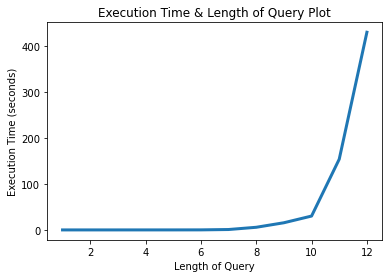

In [43]:
def recursive_lcs(Y, X, m, n): 
  
    if m == 0 or n == 0: 
        return 0; 
    elif Y[m-1] == X[n-1]: 
        return 1 + recursive_lcs(Y, X, m-1, n-1); 
    else: 
        return max(recursive_lcs(Y, X, m, n-1), recursive_lcs(Y, X, m-1, n)); 

import matplotlib.pyplot as plt

list_a = ['F','DF','AGD', 'VYBI', 'DCYPS', 'KLMADT', 'OPYTESK', 'QTYSFGHS', 'HVBFLFKGN', 'AVBFLFKGNY', 'BVBFLFKGNQU', 'HVBFLFKGNPST']
times = []
length = []

for i in range(len(list_a)):
    
    Alphabet_S = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    Input_S = list_a[i]
    
    start_time = time.time()
    
    recursive_lcs(Alphabet_S, Input_S, len(Alphabet_S), len(Input_S))
    
    t = (time.time() - start_time)
    
    l = len(Input_S)
    times.append(t)
    length.append(l)
    
plt.plot(length,times, linewidth = 3.0)
plt.xlabel('Length of Query')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time & Length of Query Plot')


### Consideration:

As we can see above the graph prove that the running time is increasing dramatically which really look like the recursive algorithm has the exponential time complexity.

3. Write a program that computes the length of the subsequence of maximum length, using dynamic programming.

In [45]:
import time
start_time = time.time()

def longest_common_subsequence(S1 , S2):
    
    m = len(S1) 
    n = len(S2) 

    # declaring the array for storing the dp values 
    L = [[None]*(n+1) for i in range(m+1)] 

    """Following steps build L[m+1][n+1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m+1): 
        for j in range(n+1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif S1[i-1] == S2[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j] , L[i][j-1]) 

    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n]

print("--- %s seconds ---" % (time.time() - start_time))
    
Input_S = input("Please enter a sequence with upper cases: ")
Alphabet_S = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

if Input_S.isalpha() and Input_S.isupper():
    print ("Length of LCS is ", longest_common_subsequence(Input_S, Alphabet_S))
else:
    print ('Please enter a string with only upper case letters in English!')
       

--- 0.0 seconds ---
Please enter a sequence with upper cases: ABCYDEUFG
Length of LCS is  7


### Considerations:
As we have tried several times with short strings that can be proven whether the function is finding correct answer or not, our function has returned correct answer for all different inputs. Since we have conditioned the input that all strings can only contain the letters of English alphabet it also makes sure that we have a correct input. Howewer, the dynamic algorithm finds the longest subsequence really quick even for the string that has a really long length.

4. What is its runtime complexity?

### Consideration:
We have tried the dynamic algorithm with different strings that have really long length but the algorithm has returned the result quickly since it has the O(mn) runtime complexity.

Credit to: Back To Back SWE https://www.youtube.com/watch?v=ASoaQq66foQ